In [1]:
from tsai.all import (
    TSStandardScaler,
    plt,
    TSShrinkDataFrame,
    TSDropDuplicates,
    TSFillMissing,
    TSForecaster,
    ShowGraph,
    SaveModel,
    ContextManagers,
    mse,
    mae,
    mkdir,
    save_object,
    load_object,
    load_learner,
    to_np,
    plot_forecast,
)

# import optuna
# from optuna.integration import FastAIPruningCallback

from sklearn.metrics import mean_squared_error, mean_absolute_error

from tsai.basics import (
    get_forecasting_splits,
    prepare_forecasting_data
)

from pathlib import Path
import pandas as pd
import sklearn


In [3]:
file_path = Path("../data/example_data.hd5")
df = pd.read_hdf(file_path)
df = df.reset_index()
df

,PropertyID,DateTime,Value
0,300468,2020-01-01 00:00:00,65.992325
1,300468,2020-01-01 00:00:30,59.085239
2,300468,2020-01-01 00:01:00,63.399876
3,300468,2020-01-01 00:01:30,74.437500
4,300468,2020-01-01 00:02:00,60.391750
...,...,...,...
17007,315036,2020-01-01 23:54:00,113.592300
17008,315036,2020-01-01 23:55:00,113.462090
17009,315036,2020-01-01 23:56:00,113.505493
17010,315036,2020-01-01 23:58:00,113.042534


In [4]:
df = df.pivot(index='DateTime', columns='PropertyID', values='Value')
df.columns = [str(col) for col in df.columns]
df = df.reset_index()
df.rename(columns={'DateTime':'date'}, inplace=True)
# TODO: Remove this, simply test whether it's okay to drop rows with na
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df

,date,300468,300498,305256,315036,340686,341124,341550
0,2020-01-01 00:00:00,65.992325,2036.845581,58.777546,114.388023,1.737929,5.342316,1.386370
1,2020-01-01 00:01:00,63.399876,2036.780151,72.960365,114.293983,1.861186,5.308666,1.416289
2,2020-01-01 00:02:00,60.391750,2036.780518,70.489014,114.120377,1.729635,5.588947,1.548172
3,2020-01-01 00:03:00,90.420456,2036.791260,69.030907,113.982925,1.846162,5.214818,1.571617
4,2020-01-01 00:04:00,49.318005,2036.515869,64.157204,114.120377,1.823215,2.415242,1.383088
...,...,...,...,...,...,...,...,...
1278,2020-01-01 23:54:00,61.276802,2031.322998,61.969559,113.592300,1.098813,1.395472,0.412474
1279,2020-01-01 23:55:00,109.579590,2031.325073,64.374786,113.462090,1.174195,1.415452,0.409055
1280,2020-01-01 23:56:00,91.558792,2031.323853,69.043365,113.505493,1.078580,1.368477,0.415957
1281,2020-01-01 23:58:00,88.076408,2030.877808,60.180309,113.042534,1.058243,1.402138,0.439101


In [5]:
datetime_col = "date"
columns = df.columns[1:]
method = 'ffill'
artifacts_path = Path('artifacts/')

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
        # shrink dataframe memory usage
        ('shrinker', TSShrinkDataFrame()), 
        # drop duplicate rows (if any)
        ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)),
        # fill missing data (1st ffill. 2nd value=0)
        # ('fill_missing', TSFillMissing(columns=columns, method=method)), 
    ], 
    verbose=True
)
mkdir(artifacts_path, exist_ok=True, parents=True)
save_object(preproc_pipe, artifacts_path / 'preproc_pipe.pkl')
preproc_pipe = load_object(artifacts_path / 'preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df)
df

artifacts directory already exists.
Pipeline saved as artifacts/preproc_pipe.pkl
Initial memory usage: 80.32 KB  
Final memory usage  : 45.23 KB   (-43.7%)
[Pipeline] .......... (step 1 of 2) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 2) Processing drop_duplicates, total=   0.0s


,date,300468,300498,305256,315036,340686,341124,341550
0,2020-01-01 00:00:00,65.992325,2036.845581,58.777546,114.388023,1.737929,5.342316,1.386370
1,2020-01-01 00:01:00,63.399876,2036.780151,72.960365,114.293983,1.861186,5.308666,1.416289
2,2020-01-01 00:02:00,60.391750,2036.780518,70.489014,114.120377,1.729635,5.588947,1.548172
3,2020-01-01 00:03:00,90.420456,2036.791260,69.030907,113.982925,1.846162,5.214818,1.571617
4,2020-01-01 00:04:00,49.318005,2036.515869,64.157204,114.120377,1.823215,2.415242,1.383088
...,...,...,...,...,...,...,...,...
1278,2020-01-01 23:54:00,61.276802,2031.322998,61.969559,113.592300,1.098813,1.395472,0.412474
1279,2020-01-01 23:55:00,109.579590,2031.325073,64.374786,113.462090,1.174195,1.415452,0.409055
1280,2020-01-01 23:56:00,91.558792,2031.323853,69.043365,113.505493,1.078580,1.368477,0.415957
1281,2020-01-01 23:58:00,88.076408,2030.877808,60.180309,113.042534,1.058243,1.402138,0.439101


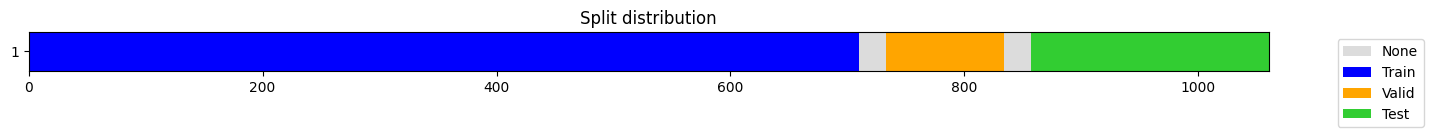

((#710) [0,1,2,3,4,5,6,7,8,9...],
 (#101) [733,734,735,736,737,738,739,740,741,742...],
 (#203) [857,858,859,860,861,862,863,864,865,866...])

In [6]:
fcst_history = 200    # steps in the past
fcst_horizon = 24     # steps in the future
valid_size   = 0.1    # int or float indicating the size of the training set
test_size    = 0.2    # int or float indicating the size of the test set

splits = get_forecasting_splits(
    df, 
    fcst_history=fcst_history, 
    fcst_horizon=fcst_horizon, 
    datetime_col=datetime_col,
    valid_size=valid_size, 
    test_size=test_size
)
splits

In [7]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline(
    [
        # standardize data using train_split
        ('scaler', TSStandardScaler(columns=columns)), 
    ], 
    verbose=True)
save_object(exp_pipe, artifacts_path / 'exp_pipe.pkl')
exp_pipe = load_object(artifacts_path / 'exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

artifacts directory already exists.
Pipeline saved as artifacts/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,date,300468,300498,305256,315036,340686,341124,341550
0,2020-01-01 00:00:00,-0.034140,1.753821,-0.997348,-0.442145,0.175953,1.879950,0.998984
1,2020-01-01 00:01:00,-0.170218,1.692355,1.498397,-0.514581,0.468875,1.855702,1.122499
2,2020-01-01 00:02:00,-0.328115,1.692699,1.063514,-0.648305,0.156243,2.057668,1.666950
3,2020-01-01 00:03:00,1.248099,1.702791,0.806932,-0.754179,0.433171,1.788076,1.763738
4,2020-01-01 00:04:00,-0.909379,1.444087,-0.050692,-0.648305,0.378637,-0.229256,0.985435
...,...,...,...,...,...,...,...,...
1278,2020-01-01 23:54:00,-0.281658,-3.434135,-0.435651,-1.055066,-1.342915,-0.964087,-3.021541
1279,2020-01-01 23:55:00,2.253766,-3.432186,-0.012404,-1.155363,-1.163769,-0.949689,-3.035656
1280,2020-01-01 23:56:00,1.307850,-3.433332,0.809124,-1.121931,-1.390999,-0.983539,-3.007163
1281,2020-01-01 23:58:00,1.125059,-3.852350,-0.750504,-1.478534,-1.439330,-0.959283,-2.911617


In [8]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

X, y = prepare_forecasting_data(
    df, 
    fcst_history=fcst_history, 
    fcst_horizon=fcst_horizon, 
    x_vars=x_vars, 
    y_vars=y_vars
)
print(X.shape, "<-> (# samples, # features, # history timestamps) ")
print(y.shape, "<-> (# samples, # features, # future timestamps)")

(1060, 7, 200) <-> (# samples, # features, # history timestamps) 
(1060, 7, 24) <-> (# samples, # features, # future timestamps)


In [9]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [10]:
n_epochs = 100
n_layers = 12
n_heads = 8
d_model = 128
d_ff = 256
attn_dropout = 0.1
dropout = 0.1
patch_len = 24
stride = 2

arch_config = dict(
    n_layers=n_layers,
    n_heads=n_heads,  
    d_model=d_model,
    d_ff=d_ff,
    attn_dropout=attn_dropout,
    dropout=dropout,
    patch_len=patch_len,
    stride=stride,
    padding_patch=True,
)

learn = TSForecaster(
    X, 
    y, 
    splits=splits, 
    path=artifacts_path,
    batch_size=64, 
    pipelines=[preproc_pipe, exp_pipe],
    arch="PatchTST", 
    arch_config=arch_config, 
    loss_func=mae,
    metrics=[mse, mae], 
    
    cbs=[ShowGraph()],
)

learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 64 x 7 x 200)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7 x 24         
RevIN                                     14         True      
____________________________________________________________________________
                     64 x 7 x 202        
ReplicationPad1d                                               
____________________________________________________________________________
                     64 x 24 x 90        
Unfold                                                         
____________________________________________________________________________
                     64 x 7 x 90 x 128   
Linear                                    3200       True      
Dropout                                                        
Linear                                    16512      True      
Linear                                    16512      True      
Linear                                    16512     

epoch,train_loss,valid_loss,mse,mae,time
0,0.821191,1.082709,3.613417,1.082709,00:03


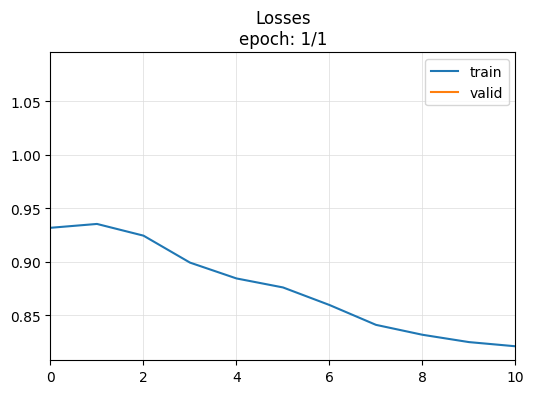

not enough values to plot a chart


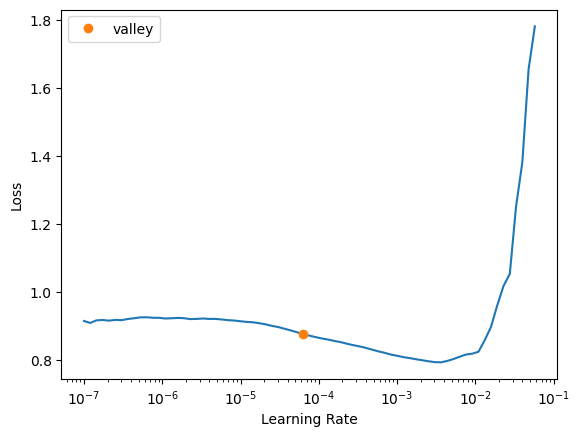

In [11]:
lr_max = learn.lr_find().valley
learn.fit_one_cycle(1, lr_max=lr_max)
learn.export('patchTST.pt')

In [12]:
learn.metrics

(#2) [<fastai.learner.AvgMetric object at 0x7f676157e750>,<fastai.learner.AvgMetric object at 0x7f676157e390>]

In [13]:
import numpy as np 
import torch 

a = torch.from_numpy(np.random.randn(5, 1))
b = torch.from_numpy(np.random.randn(5, 1))

metrics = [mse, mae]

print(metrics[0](a, b))
print(metrics[1](a, b))

TensorBase(0.7573)
TensorBase(0.8127)


In [14]:
for metric in metrics:
    print(metric.__name__)

mse
mae


In [15]:
learn = load_learner(artifacts_path / 'patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(
    scaled_y_true.flatten(), 
    scaled_preds.flatten()
)
results_df.loc["valid", "mae"] = mean_absolute_error(
    scaled_y_true.flatten(), 
    scaled_preds.flatten()
)
results_df

scaled_preds.shape: (101, 7, 24)


,mse,mae
valid,3.613417,1.082709


In [16]:
learn = load_learner(artifacts_path / 'patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(
    y_test.flatten(), 
    y_test_preds.flatten()
)
results_df.loc["test", "mae"] = mean_absolute_error(
    y_test.flatten(), 
    y_test_preds.flatten()
)
results_df

y_test_preds.shape: (203, 7, 24)


,mse,mae
test,3.800615,1.080862


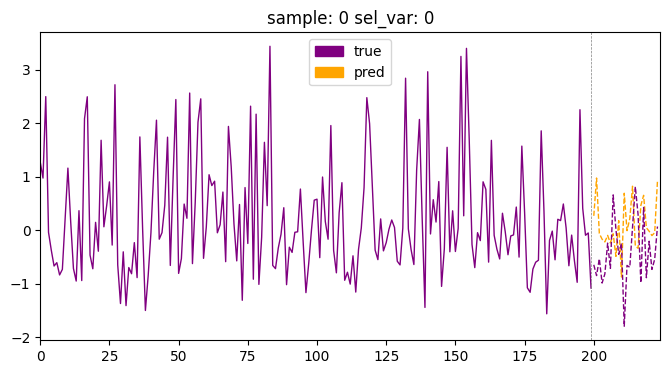

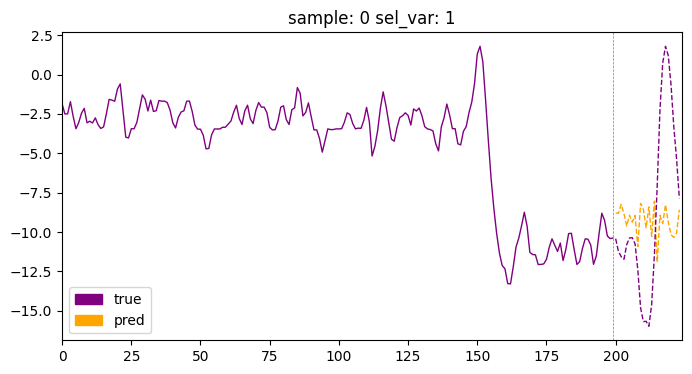

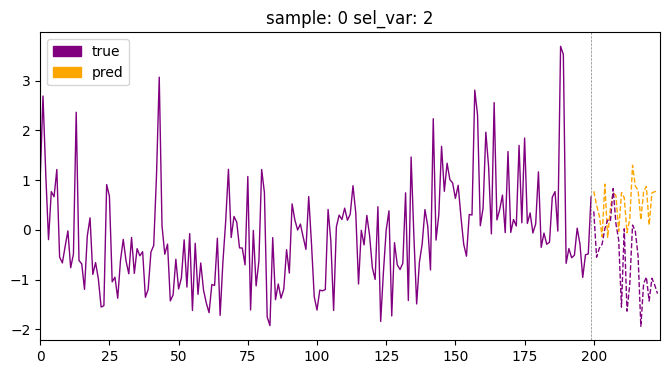

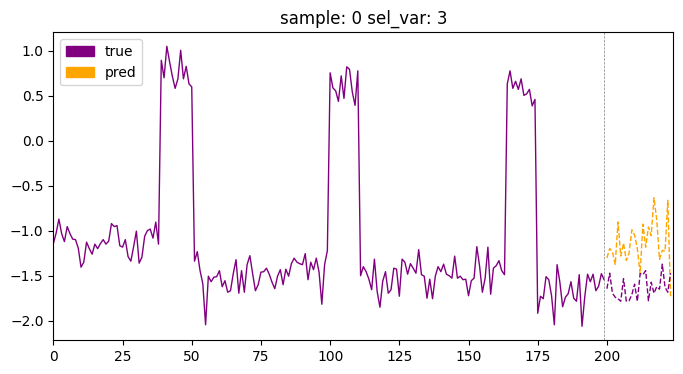

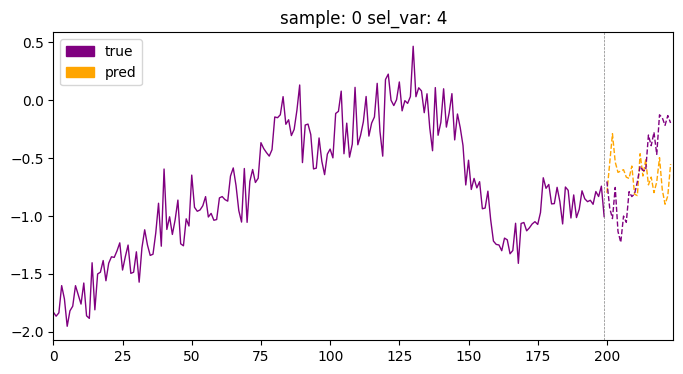

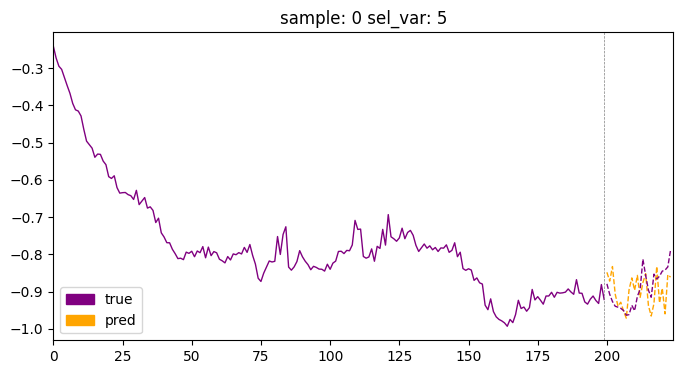

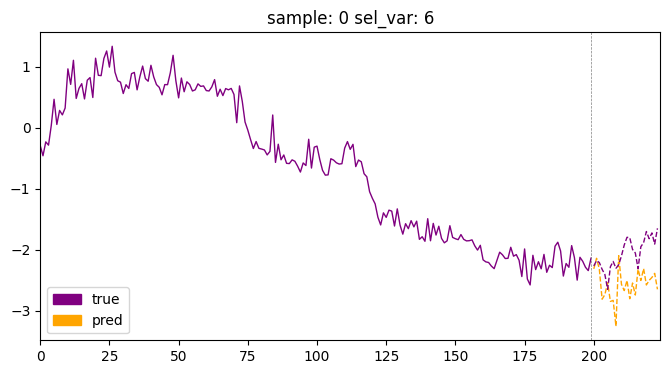

In [17]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True, idx=0)

In [18]:
X_train = X[splits[0]]
y_train = y[splits[0]]
y_train_preds, *_ = learn.get_X_preds(X_train)
y_train_preds = to_np(y_train_preds)

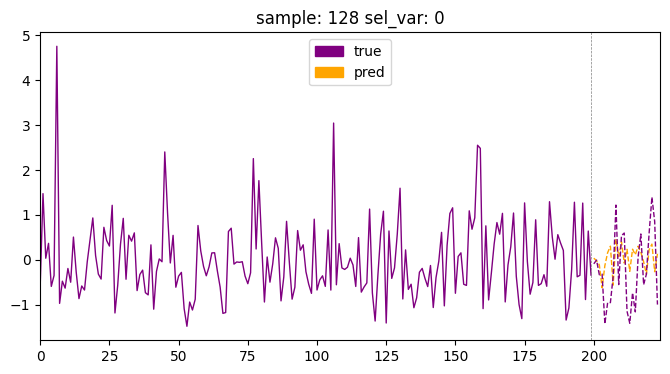

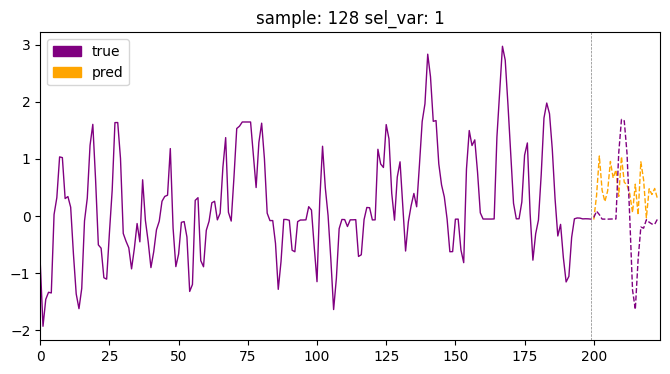

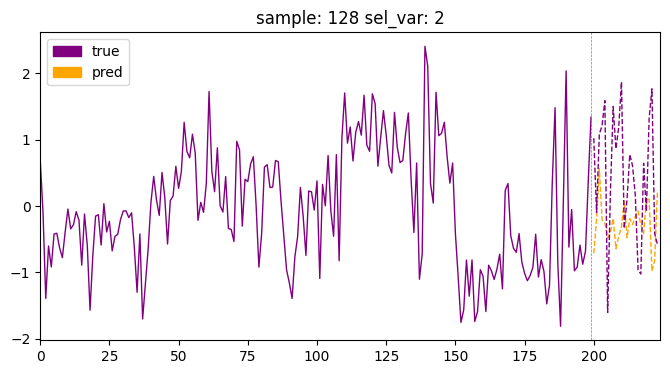

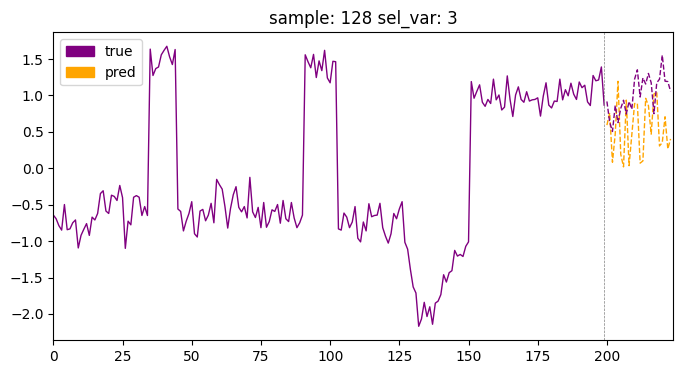

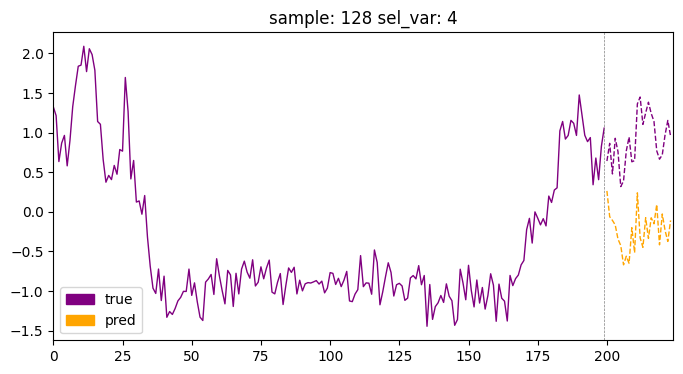

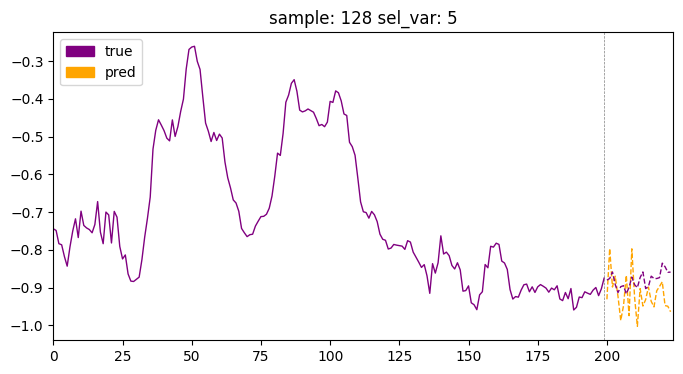

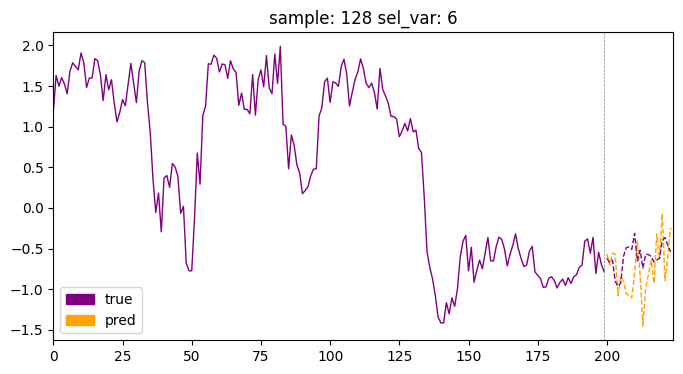

In [19]:
plot_forecast(X_train, y_train, y_train_preds, sel_vars=True, idx=128)